In [108]:
import pandas as pd
import numpy as np
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import torch

In [12]:
f_img = h5py.File("resnet_pairs.hdf5", "r")
f_text = h5py.File("tfid_pairs.hdf5", "r")

In [21]:
def ds_tolist(ds):
    return ds[()].tolist()

In [24]:
imgx = ds_tolist(f_img['indices_x'])
imgy = ds_tolist(f_img['indices_y'])
txtx = ds_tolist(f_text['indices_x'])
txty = ds_tolist(f_text['indices_y'])

In [25]:
S = set()

In [26]:
for x,y in zip(imgx, imgy): S.add((x,y))
len(S)

60000

In [27]:
for x,y in zip(txtx, txty): S.add((x,y))
len(S)

87232

In [57]:
PATH = Path('/home/slex/data/shopee')
train_df = pd.read_csv(PATH/'train_split.csv')
valid_df = train_df[train_df.split==0].copy().reset_index()


In [58]:
target_groups = valid_df.groupby('label_group').indices
valid_df['target']=valid_df.label_group.map(target_groups)

In [59]:
valid_df

,index,Unnamed: 0,posting_id,image,image_phash,title,label_group,split,target
0,6,6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,0,"[0, 555, 3076, 3987, 5624, 6241, 6419]"
1,7,7,train_1806152124,0014f61389cbaa687a58e38a97b6383d.jpg,eea7e1c0c04da33d,KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT...,1565741687,0,"[1, 1468]"
2,19,19,train_2961381387,00303ad1c062fdeaf5f41b9ffb71a5fb.jpg,e48d9b652098efe1,Madame Gie MakeUp Blush On BY GISELL,2098400894,0,"[2, 2684, 3722, 4807, 6444]"
3,23,23,train_1180155871,00369839c7d94411e54437b7cf59b603.jpg,bbc1c43ec3633ec0,[INCLUDE PAJAK] NCT DREAM RELOAD ALBUM,2224428568,0,"[3, 4905]"
4,24,24,train_1872347548,003906c6c6bba4cde15e5e854dba8f6d.jpg,f3e18c5ea14493e3,Stand Hanger Multifungsi - Tiang Gantungan Baj...,4044205497,0,"[4, 1617, 3146, 4067, 5011, 5154, 6630]"
...,...,...,...,...,...,...,...,...,...
6803,34224,34224,train_3943315801,ffc7391f30199535379accf6862e1263.jpg,a3f27e812323d46d,DETERGENT SLEEK BABY LAUNDRY KEMASAN BOTOL 1200ML,3725072369,0,"[1101, 5954, 6803, 6804]"
6804,34225,34225,train_2822476848,ffc7391f30199535379accf6862e1263.jpg,a3f27e812323d46d,Sleek Baby Laundry Detergent Botol 1200 ml / S...,3725072369,0,"[1101, 5954, 6803, 6804]"
6805,34236,34236,train_2287008377,ffdf26064e4fc46c6bbcbcd06fc5b523.jpg,c5643f31193f744a,MMTOYS MB135 Mainan Anak Marble Run 105pcs / M...,724975459,0,"[1505, 2944, 6805]"
6806,34239,34239,train_2876777099,ffea625e5d806645008a53f4dcaa7076.jpg,bbb5cc63949841b6,Active Mask Onecare 3ply Earloop (3pcs),2413419336,0,"[1615, 6806]"


In [75]:
def f1(tp, fp, num_tar):
    return 2 * tp / (tp+fp+num_tar)

def build_from_pairs(xs, ys, target):
    score =0
    tp = [0]*len(target)
    fp = [0]*len(target)
    scores=[]
    group_sizes = [len(x) for x in target]
    for x,y in zip(xs,ys):
        group_size = group_sizes[x]
        score -= f1(tp[x], fp[x], group_size)
        if y in target[x]: tp[x] +=1
        else: fp[x] +=1
        score += f1(tp[x], fp[x], group_size) 
        scores.append(score / len(target))
    plt.plot(scores)
    am =torch.tensor(scores).argmax()
    print(f'{scores[am]:.3f} at {am/len(target)} pairs')
    return scores

0.743 at 5.286868572235107 pairs


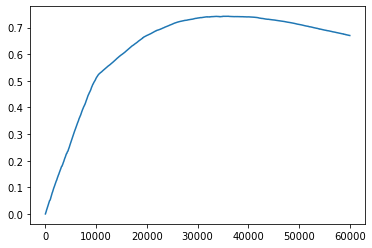

In [92]:
_=build_from_pairs(imgx, imgy, valid_df.target.to_list())

0.782 at 5.600910663604736 pairs


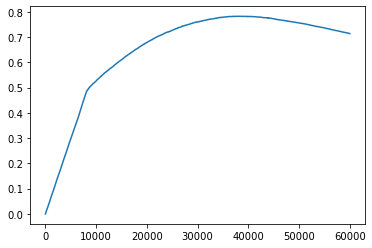

In [93]:
_=build_from_pairs(txtx, txty, valid_df.target.to_list())

In [94]:
def weave(A,B):
    R = list()
    for a,b in zip(A,B):
        R.append(a)
        R.append(b)
    return R

In [103]:
def dedupe(A,B):
    S = set()
    NA = list()
    NB = list()
    for a,b in zip(A,B):
        if not (a,b) in S:
            S.add((a,b))
            NA.append(a)
            NB.append(b)
    return NA,NB

In [104]:
combx = weave(imgx, txtx)
comby = weave(imgy, txty)
len(combx), len(comby)

(120000, 120000)

In [106]:
combx,comby = dedupe(combx,comby)
len(combx), len(comby)

(87232, 87232)

0.842 at 5.96401309967041 pairs


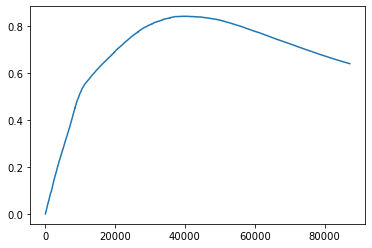

In [107]:
_=build_from_pairs(combx, comby, valid_df.target.to_list())